In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('D2.csv')
print(df.info())
# print(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5789 entries, 0 to 5788
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5789 non-null   object 
 1   age               5789 non-null   object 
 2   height            5789 non-null   int64  
 3   weight            5789 non-null   int64  
 4   blood_type        5789 non-null   object 
 5   insurance         5789 non-null   object 
 6   income            5789 non-null   object 
 7   smoking           5789 non-null   object 
 8   alcohol           5789 non-null   float64
 9   contacts_count    5789 non-null   float64
 10  working           5789 non-null   object 
 11  worried           5789 non-null   float64
 12  covid19_positive  5789 non-null   int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 588.1+ KB
None


# Task - Regression 📈

## Task 1
What pre-processing was required on the dataset before regression modelling? What distribution split between training and test datasets was used?

The answer are basically same as decision tree, but two more points should be mentioned:
+ ensure that the input variables are all numerical -> apply one 🔥 encoding.
+ Standardisation (will be explained in question 2).

## Task 2
Build a regression model using the default setting with all inputs. Build another regression model fine-tuned with GridSearchCV. Now, choose a better model to answer the followings:

In [3]:
# Data preparation 🫃🏿

# setting random state
rs = 30678

from sklearn.model_selection import train_test_split
def data_prep(df):
    df = pd.get_dummies(df) # one 🥵 
    
    y = df['covid19_positive']
    
    X = df.drop(['covid19_positive'], axis=1)    
    
    X_mat = X.to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)
    return df,X,y,X_train, X_test, y_train, y_test

df,X,y,X_train, X_test, y_train, y_test = data_prep(df)

In [4]:
# Standardisation 🤗

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

print("Before scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

X_train = scaler.fit_transform(X_train, y_train)

print("After scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

X_test = scaler.transform(X_test)

Before scaling
-------------
Variable #0: min 110, max 228, mean 171.90 and std dev 10.93
Variable #1: min 44, max 180, mean 84.70 and std dev 23.34
Variable #2: min 0.0, max 14.0, mean 2.68 and std dev 3.13
Variable #3: min 0.0, max 21.0, mean 7.87 and std dev 6.70
Variable #4: min 1.0, max 5.0, mean 3.64 and std dev 0.72
After scaling
-------------
Variable #0: min -5.66385424611233, max 5.133102192047165, mean -0.00 and std dev 1.00
Variable #1: min -1.7438704260112774, max 4.083751483723398, mean 0.00 and std dev 1.00
Variable #2: min -0.8575106988353736, max 3.619697485567119, mean 0.00 and std dev 1.00
Variable #3: min -1.173975606905906, max 1.9592280546954912, mean -0.00 and std dev 1.00
Variable #4: min -3.676761824558861, max 1.8890321095449987, mean 0.00 and std dev 1.00


In [5]:
# Train/build the default model 🏋🏿‍♂️

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

default_model = LogisticRegression(random_state=rs)
# fit it to training data
default_model.fit(X_train, y_train)

# training and test accuracy
print("default_model train accuracy:", default_model.score(X_train, y_train))
print("default_model test accuracy:", default_model.score(X_test, y_test))

# classification report on test data
y_pred = default_model.predict(X_test)
# print(classification_report(y_test, y_pred))

default_model train accuracy: 0.6991609081934848
default_model test accuracy: 0.6827864133563616


In [6]:
# top 🖐🏿 feature important variables

cv_coef = default_model.coef_[0]
cv_feature_names = X.columns

# sort them out in descending order
cv_indices = np.argsort(np.absolute(cv_coef))
cv_indices = np.flip(cv_indices, axis=0)

for i in cv_indices[:5]: # limit to 5 features,
    print(cv_feature_names[i], ':', cv_coef[i])

income_high : -0.3691590774201163
weight : 0.3342089754085905
income_med : 0.3336072846977869
working_travel critical : 0.23521670785064988
age_100_110 : 0.2179262618985691


In [7]:
# Train/build the model (cv_model) using GridSearchCV 🏋🏿‍♂️🏋🏿🏋🏿‍♂️🏋🏿🏋🏿‍♂️🏋🏿🏋🏿‍♂️🏋🏿🏋🏿‍♂️🏋🏿🏋🏿‍♂️🏋🏿🏋🏿‍♂️🏋🏿

from sklearn.model_selection import GridSearchCV
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv_model = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs),return_train_score=True, cv=10, n_jobs=-1)
cv_model.fit(X_train, y_train) 

# print the best parameter
print(cv_model.best_params_)

{'C': 1}


Total number of models:  10


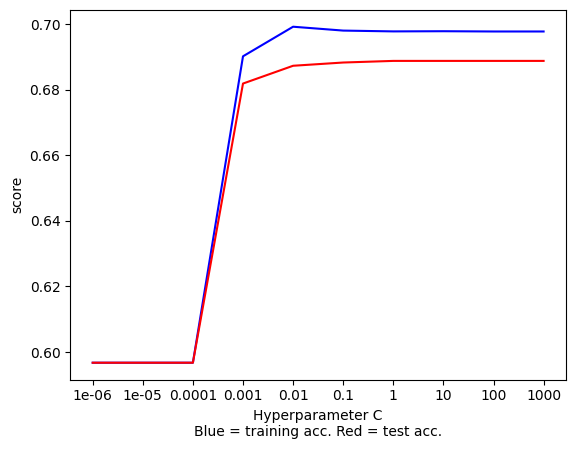

In [8]:
import matplotlib.pyplot as plt
result_set = cv_model.cv_results_
train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']
print("Total number of models: ", len(test_result))
# plot Hyperparameter C values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter C\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),[pow(10, x) for x in range(-6, 4)])
plt.ylabel('score')
plt.show()

In [9]:
# accuracy for cv_model
print("cv_model train accuracy:", cv_model.score(X_train, y_train))
print("cv_model test accuracy:", cv_model.score(X_test, y_test))

cv_model train accuracy: 0.6991609081934848
cv_model test accuracy: 0.6827864133563616


### Task 2-a. Explain why you chose that model.

LOL, the models are identical! Why? because it happens to the best case generated by GridSearchCV has the same value of hyperparameter C (which is 1).

### Task 2-b. Name the regression function used

👉🏻 Logistic regression

### Task 2-c. Did you apply standardisation of variables? Why would you standardise the variables for regression mining?

Yes, we did. 

Cause regression model is sensitive to input variables on different scales. If the input variables are on different scales, it makes the algorithm difficult to compare between data points. Rounding down the scale for all input variables also help with faster training process as it can update coefficients much faster. 

### Task 2-d. Report the variables included in the regression model

We choose all

### Task 2-e. Report the top-5 important variables (in the order) in the model

Refer to the code above

### Task 2-f. What is the classification accuracy on training and test datasets?


Refer to the code above

### Task 2-g. Report any sign of overfitting in this model

There is a slight overfitting for both models. 

## Task 3
Build another regression model on the reduced variables set. Perform dimensionality reduction with Recursive feature elimination. Fine-tune the model with GridSearchCV to find the best parameter setting. Answer the followings:

In [10]:
# performing recursive feature elimination (RFE)

from sklearn.feature_selection import RFECV
rfe_model = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe_model.fit(X_train, y_train) # run the RFECV
# comparing how many variables before and after
print("Original feature set", X_train.shape[1])
print("Number of features after elimination", rfe_model.n_features_)

Original feature set 45
Number of features after elimination 26


In [11]:
# top ➂ feature important variables

coef_rfe = rfe_model.estimator_.coef_[0]

# Get the names of the features (choose the only selected variables)
feature_names_rfe = X.columns[rfe_model.support_]

# sort it!!
indices_rfe = np.argsort(np.absolute(coef_rfe))
indices_rfe = np.flip(indices_rfe, axis=0)

for i in indices_rfe[:3]: # limit to 3 features
    print(feature_names_rfe[i], ':', coef_rfe[i])

income_med : 0.3613967080362295
income_high : -0.34503427168863166
weight : 0.3298753405538736


In [12]:
# train/build rfe_cv_model

# apply the only selected variables
X_train_sel = rfe_model.transform(X_train)
X_test_sel = rfe_model.transform(X_test)

# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

# NOTE: same here, we set `max_iter` to 150, 
rfe_cv_model = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
rfe_cv_model.fit(X_train_sel, y_train)

# test the best model
print("Train accuracy:", rfe_cv_model.score(X_train_sel, y_train))
print("Test accuracy:", rfe_cv_model.score(X_test_sel, y_test))

y_pred = rfe_cv_model.predict(X_test_sel)
# print(classification_report(y_test, y_pred))

# print parameters of the best model
print(rfe_cv_model.best_params_)

Train accuracy: 0.6979269496544916
Test accuracy: 0.6827864133563616
{'C': 1}


### Task 3-a. Was dimensionality reduction useful to identify a good feature set for building an accurate model?

🤔

### Task 3-b. What is the classification accuracy on training and test datasets?

### Task 3-c. Report any sign of overfitting.

### Task 3-d. Report the top-3 important variables (in the order) in the model

## Task 4
Produce the ROC curve for all different regression models. Using the best regression model, can you identify which individuals could potentially be "COVID positive"? Provide the general characteristics of those individuals.

There are 3 models created:
1. **default_model**: the model using the default setting with all inputs
1. **cv_model**: the model fine-tuned with GridSearchCV.
1. **rfe_cv_model**: the model on the reduced variables set (Recursive feature elimination) and fine-tuned with GridSearchCV.

In [13]:
from sklearn.metrics import roc_auc_score

y_default_proba = default_model.predict_proba(X_test)
y_cv_proba = cv_model.predict_proba(X_test)
y_rfe_cv_proba = rfe_cv_model.predict_proba(X_test_sel)
roc_index_default = roc_auc_score(y_test, y_default_proba[:, 1])
roc_index_cv = roc_auc_score(y_test, y_cv_proba[:, 1])
roc_index_rfe_cv = roc_auc_score(y_test, y_rfe_cv_proba[:, 1])

print("ROC index on test for default_model:", roc_index_default)
print("ROC index on test for cv_model:", roc_index_cv)
print("ROC index on test for rfe_cv_model:", roc_index_rfe_cv)

ROC index on test for default_model: 0.725214668509961
ROC index on test for cv_model: 0.725214668509961
ROC index on test for rfe_cv_model: 0.7261324142565226


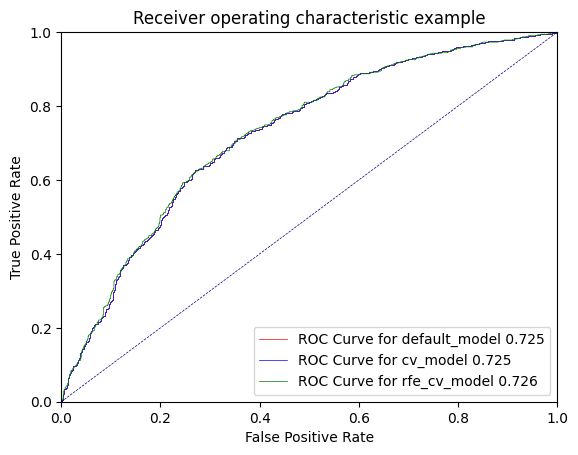

In [14]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_default, tpr_default, thresholds_default = roc_curve(y_test, y_default_proba[:,1])
fpr_cv, tpr_cv, thresholds_cv = roc_curve(y_test, y_cv_proba[:,1])
fpr_rfe_cv, tpr_rfe_cv, thresholds_rfe_cv = roc_curve(y_test, y_rfe_cv_proba[:,1])

plt.plot(fpr_default, tpr_default, label='ROC Curve for default_model {:.3f}'.format(roc_index_default), color='red', lw=0.5)
plt.plot(fpr_cv, tpr_cv, label='ROC Curve for cv_model {:.3f}'.format(roc_index_cv), color='blue', lw=0.5)
plt.plot(fpr_rfe_cv, tpr_rfe_cv, label='ROC Curve for rfe_cv_model {:.3f}'.format(roc_index_rfe_cv), color='green', lw=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

The general characteristics of those individuals who get covid positive: 

We can discover this by looking at the top 10 important features of our best model. </br>
Why? Beacuse remember that linear/logistic regressioin model assumes a linear correlation between input variables and target values ("covid_positive" in our case). The relationship is reflected in the weight (slope) values. 

In [17]:
for i in indices_rfe[:]:
    print(feature_names_rfe[i], ':', coef_rfe[i])

income_med : 0.3613967080362295
income_high : -0.34503427168863166
weight : 0.3298753405538736
working_travel critical : 0.2604512269127853
age_100_110 : 0.22688049252442857
height : -0.1949907267986369
age_70_80 : -0.19171436296338648
age_60_70 : -0.13383568361293208
working_home : -0.1321295525976445
worried : 0.1167345184176584
age_20_30 : 0.11096770572640921
smoking_quit5 : -0.10729945201869477
income_gov : 0.10544937880419927
smoking_never : -0.10261329986518831
working_travel non critical : -0.07452821024733453
age_40_50 : -0.07129521941996704
gender_other : 0.06951858617521091
blood_type_abp : 0.06641176900367318
gender_female : -0.06001550097332776
insurance_yes : 0.05470589394224918
insurance_no : -0.05470589394224879
blood_type_unknown : 0.053564818370763385
smoking_yesheavy : 0.04689905125375504
smoking_quit10 : 0.04338867752054143
blood_type_an : -0.04309025769700249
alcohol : 0.034340455483120945


The result shows the correlation between input and output variable. 


How to interpret it?</br> Examples:
- `income_high` has a negative coefficient, meaning that high income individuals are less likely to test positive for covid-19.
- `working_travel critical` has a positive coefficient, meaning those who travel a lot for work would very likely to test positive for covid-19.
- ...
